In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
import pyspark as ps    # for the pyspark suite
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

# Data preprocessing

## EDA

In [126]:
df1 = pd.read_csv("data.csv", encoding = "ISO-8859-1");df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [127]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df1["InvoiceDate"] = df1["InvoiceDate"].apply(lambda x: pd.to_datetime(x.split(" ")[0]))

In [ ]:
df1["InvoiceDate"].describe()

In [147]:
g = df1.groupby("InvoiceDate")

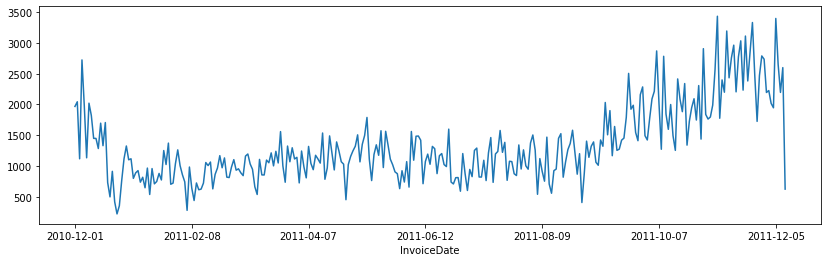

In [10]:
g.InvoiceNo.count().plot(figsize=(14,4))

In [149]:
df1.dropna(inplace = True)

In [150]:
df1.to_csv("data2.csv")

In [2]:
df = pd.read_csv("data2.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   406829 non-null  int64  
 1   InvoiceNo    406829 non-null  object 
 2   StockCode    406829 non-null  object 
 3   Description  406829 non-null  object 
 4   Quantity     406829 non-null  int64  
 5   InvoiceDate  406829 non-null  object 
 6   UnitPrice    406829 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      406829 non-null  object 
 9   sales        406829 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 31.0+ MB


In [8]:
df.describe()

,Unnamed: 0,Quantity,UnitPrice,CustomerID,sales
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,278048.159318,12.061303,3.460471,15287.690570,20.401854
std,152744.019884,248.693370,69.315162,1713.600303,427.591718
min,0.000000,-80995.000000,0.000000,12346.000000,-168469.600000
25%,147749.000000,2.000000,1.250000,13953.000000,4.200000
50%,284435.000000,5.000000,1.950000,15152.000000,11.100000
75%,409528.000000,12.000000,3.750000,16791.000000,19.500000
max,541908.000000,80995.000000,38970.000000,18287.000000,168469.600000


In [4]:
df["sales"] = df["Quantity"] * df["UnitPrice"]

In [5]:
g = df.groupby("InvoiceDate")

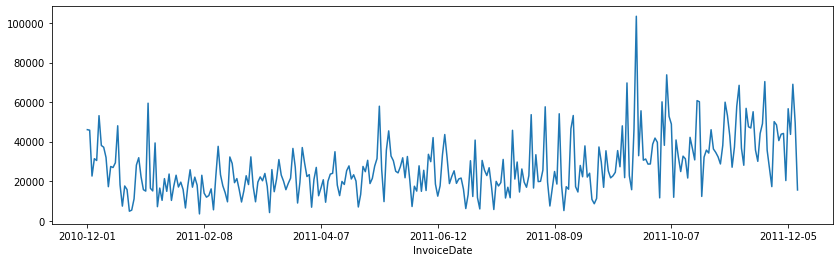

In [7]:
g.sales.sum().plot(figsize=(14,4))

-----

# Data pineline

In [7]:
df = spark.read.csv('data2.csv',
                    header=True,       # use headers or not
                    quote='"',         # char for quotes
                    sep=",",           # char for separation
                    inferSchema=True)  # do we infer schema or not ?

In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [9]:
df.createOrReplaceTempView('trans')

In [104]:
query = """SELECT distinct CustomerID, 
                min(InvoiceDate) as first_purchase_date,
                max(InvoiceDate) as last_purchase_date,
                count(distinct InvoiceDate) as total_purchases,
                sum(Quantity * UnitPrice) as total_purchase_amount,
                SUM(CASE WHEN InvoiceDate > '2011-07-31' THEN Quantity * UnitPrice ELSE 0 END) AS last_2_months_spend
                FROM trans
                WHERE InvoiceDate between '2010-11-30' and '2011-10-01'
                GROUP BY CustomerID
             """
sdf = spark.sql(query)
sdf.show()

+----------+-------------------+-------------------+---------------+---------------------+-------------------+
|CustomerID|first_purchase_date| last_purchase_date|total_purchases|total_purchase_amount|last_2_months_spend|
+----------+-------------------+-------------------+---------------+---------------------+-------------------+
|   13094.0|2010-12-06 00:00:00|2011-09-20 00:00:00|             14|   1556.2200000000003|  457.9200000000001|
|   14024.0|2011-08-07 00:00:00|2011-08-10 00:00:00|              2|                327.7|              327.7|
|   16596.0|2010-12-08 00:00:00|2010-12-08 00:00:00|              1|               120.65|                0.0|
|   13533.0|2011-03-17 00:00:00|2011-06-10 00:00:00|              2|               270.79|                0.0|
|   17633.0|2010-12-15 00:00:00|2011-09-29 00:00:00|              4|                937.0|             1004.5|
|   17884.0|2010-12-03 00:00:00|2011-02-01 00:00:00|              3|               602.84|                0.0|
|

In [105]:
rdf = sdf.toPandas()

In [ ]:
pd.to_datetime(rdf.last_purchase_date).max()

In [ ]:
pd.to_datetime(rdf.first_purchase_date).min()

In [106]:
rdf

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount,last_2_months_spend
0,13094.0,2010-12-06,2011-09-20,14,1556.22,457.92
1,14024.0,2011-08-07,2011-08-10,2,327.70,327.70
2,16596.0,2010-12-08,2010-12-08,1,120.65,0.00
3,13533.0,2011-03-17,2011-06-10,2,270.79,0.00
4,17633.0,2010-12-15,2011-09-29,4,937.00,1004.50
...,...,...,...,...,...,...
3653,15510.0,2011-01-13,2011-01-13,1,250.00,0.00
3654,17551.0,2010-12-15,2010-12-15,1,306.84,0.00
3655,16162.0,2011-04-01,2011-04-01,1,37.40,0.00
3656,14155.0,2011-03-18,2011-03-18,1,118.75,0.00


In [107]:
rdf = sdf.toPandas()
rdf.to_csv("predictor.csv")

In [108]:
query = """SELECT distinct CustomerID, 
                min(InvoiceDate) as first_purchase_date,
                max(InvoiceDate) as last_purchase_date,
                count(distinct InvoiceDate) as total_purchases,
                sum(Quantity * UnitPrice) as total_purchase_amount
                FROM trans
                WHERE InvoiceDate between '2011-09-30' and '2011-12-01'
                GROUP BY CustomerID
             """
sdf = spark.sql(query)
sdf.show()

+----------+-------------------+-------------------+---------------+---------------------+
|CustomerID|first_purchase_date| last_purchase_date|total_purchases|total_purchase_amount|
+----------+-------------------+-------------------+---------------+---------------------+
|   16561.0|2011-10-11 00:00:00|2011-10-11 00:00:00|              1|   264.96000000000004|
|   16596.0|2011-11-24 00:00:00|2011-11-24 00:00:00|              1|                129.5|
|   17633.0|2011-10-06 00:00:00|2011-11-08 00:00:00|              2|   305.34000000000003|
|   16916.0|2011-11-16 00:00:00|2011-11-16 00:00:00|              1|   378.17999999999995|
|   13956.0|2011-10-16 00:00:00|2011-10-16 00:00:00|              1|   189.64999999999998|
|   14768.0|2011-11-22 00:00:00|2011-11-22 00:00:00|              1|   59.400000000000006|
|   13918.0|2011-10-21 00:00:00|2011-10-21 00:00:00|              1|   1014.6399999999999|
|   14452.0|2011-11-29 00:00:00|2011-11-29 00:00:00|              1|   137.07000000000002|

In [109]:
pdf = sdf.toPandas()
pdf.to_csv("target.csv")

## Churn Model

In [74]:
# Datebase for Churn prediction
fdf = pd.merge(rdf, pdf[["CustomerID","total_purchase_amount"]], how="left", left_on="CustomerID", right_on="CustomerID")
fdf.rename({"total_purchase_amount_y":"next_2_months_spend"}, axis=1, inplace=True)
fdf["churn"] = fdf["next_2_months_spend"].apply(lambda x:0 if x>0 else 1)

df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_churn_train.csv")
df_test.to_csv("fdb_churn_test.csv")

## RFM Model


In [110]:
rdf = pd.read_csv("predictor.csv",index_col=0)
pdf = pd.read_csv("target.csv", index_col=0)

In [111]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3658 entries, 0 to 3657
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             3658 non-null   float64
 1   first_purchase_date    3658 non-null   object 
 2   last_purchase_date     3658 non-null   object 
 3   total_purchases        3658 non-null   int64  
 4   total_purchase_amount  3658 non-null   float64
 5   last_2_months_spend    3658 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 200.0+ KB


In [112]:
# Datebase for RFM prediction
# pdf["recency"] = pd.to_datetime("2013-03-02") - pd.to_datetime(pdf["last_purchase_date"]) 
pdf["recency"] = pd.to_datetime('2011-12-01') - pd.to_datetime(pdf["last_purchase_date"])
pdf["recency"] = pdf["recency"].apply(lambda x:x.days)
pdf["monetery"] = pdf["total_purchase_amount"]/pdf["total_purchases"]
pdf.rename({"total_purchases" : "frequency"},
           axis = 1,
          inplace = True)

In [113]:
pdf[["recency",'frequency','monetery']].describe()

,recency,frequency,monetery
count,2466.000000,2466.000000,2466.000000
mean,22.894566,1.896999,403.215823
std,17.140969,1.808234,562.731309
min,1.000000,1.000000,-788.380000
25%,9.000000,1.000000,170.891667
50%,18.000000,1.000000,292.270000
75%,36.000000,2.000000,449.678750
max,62.000000,37.000000,13602.470000


In [114]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(2, 0, -1); f_labels = range(1, 3)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(pdf['recency'], [0,0.25,1], labels=r_labels, duplicates='drop')
# Assign these labels to 4 equal percentile groups y_test2
f_groups = pd.qcut(pdf['frequency'], [0,0.75,1], labels=f_labels, duplicates='drop')
# Create new columns R and F 
pdf = pdf.assign(R = r_groups.values, F = f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 3)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(pdf['monetery'], [0,0.25,1], labels=m_labels, duplicates='drop')
# Create new column M
pdf = pdf.assign(M = m_groups.values)

In [115]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 2465
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CustomerID             2466 non-null   float64 
 1   first_purchase_date    2466 non-null   object  
 2   last_purchase_date     2466 non-null   object  
 3   frequency              2466 non-null   int64   
 4   total_purchase_amount  2466 non-null   float64 
 5   recency                2466 non-null   int64   
 6   monetery               2466 non-null   float64 
 7   R                      2466 non-null   category
 8   F                      2466 non-null   category
 9   M                      2466 non-null   category
dtypes: category(3), float64(3), int64(2), object(2)
memory usage: 161.7+ KB


In [116]:
pdf["RFM"] = pdf["R"].astype(str) + "-"  + pdf["F"].astype(str) + "-" + pdf["M"].astype(str)

# Datebase for RFM prediction
# fdf = pd.merge(rdf, pdf[["id","RFM", "monetery"]], how="left", left_on="id", right_on="id")
fdf = pd.merge(rdf, pdf[["CustomerID","RFM","total_purchase_amount"]], how="left", left_on="CustomerID", right_on="CustomerID")

fdf.rename({"total_purchase_amount_y":"next_2_months_spend"}, axis=1, inplace=True)
fdf["RFM"] = fdf["RFM"].fillna("1-1-1")
fdf["next_2_months_spend"] = fdf["next_2_months_spend"].fillna(0)

df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_RFM3_train.csv")
df_test.to_csv("fdb_RFM3_test.csv")

In [117]:
fdf["RFM"].value_counts()

1-1-1    2139
1-1-2     785
2-2-2     230
2-1-2     210
1-2-2     141
2-1-1      68
2-2-1      45
1-2-1      40
Name: RFM, dtype: int64

In [118]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3658 entries, 0 to 3657
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               3658 non-null   float64
 1   first_purchase_date      3658 non-null   object 
 2   last_purchase_date       3658 non-null   object 
 3   total_purchases          3658 non-null   int64  
 4   total_purchase_amount_x  3658 non-null   float64
 5   last_2_months_spend      3658 non-null   float64
 6   RFM                      3658 non-null   object 
 7   next_2_months_spend      3658 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 257.2+ KB


In [119]:
df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("fdb_RFM3_train.csv")
df_test.to_csv("fdb_RFM3_test.csv")

## Data for supervised learning

In [12]:
query = """SELECT distinct CustomerID, 
                min(InvoiceDate) as first_purchase_date,
                max(InvoiceDate) as last_purchase_date,
                count(distinct InvoiceDate) as total_purchases,
                sum(Quantity * UnitPrice) as total_purchase_amount
                FROM trans
                WHERE InvoiceDate between '2010-11-30' and '2011-08-01'
                GROUP BY CustomerID
             """
sdf = spark.sql(query)
sdf.show()
rdf = sdf.toPandas()

+----------+-------------------+-------------------+---------------+---------------------+
|CustomerID|first_purchase_date| last_purchase_date|total_purchases|total_purchase_amount|
+----------+-------------------+-------------------+---------------+---------------------+
|   13094.0|2010-12-06 00:00:00|2011-07-06 00:00:00|             12|   1098.3000000000002|
|   16596.0|2010-12-08 00:00:00|2010-12-08 00:00:00|              1|               120.65|
|   13533.0|2011-03-17 00:00:00|2011-06-10 00:00:00|              2|               270.79|
|   17884.0|2010-12-03 00:00:00|2011-02-01 00:00:00|              3|               602.84|
|   13956.0|2011-03-13 00:00:00|2011-07-24 00:00:00|              3|               680.27|
|   12493.0|2011-05-26 00:00:00|2011-06-27 00:00:00|              3|               416.79|
|   17633.0|2010-12-15 00:00:00|2010-12-15 00:00:00|              1|                -67.5|
|   16916.0|2010-12-02 00:00:00|2010-12-02 00:00:00|              1|   198.07999999999996|

In [13]:
query = """SELECT distinct CustomerID, 
                min(InvoiceDate) as first_purchase_date,
                max(InvoiceDate) as last_purchase_date,
                count(distinct InvoiceDate) as total_purchases,
                sum(Quantity * UnitPrice) as total_purchase_amount
                FROM trans
                WHERE InvoiceDate between '2011-07-31' and '2011-10-01'
                GROUP BY CustomerID
             """
sdf = spark.sql(query)
sdf.show()
pdf = sdf.toPandas()

+----------+-------------------+-------------------+---------------+---------------------+
|CustomerID|first_purchase_date| last_purchase_date|total_purchases|total_purchase_amount|
+----------+-------------------+-------------------+---------------+---------------------+
|   14024.0|2011-08-07 00:00:00|2011-08-10 00:00:00|              2|                327.7|
|   17633.0|2011-08-11 00:00:00|2011-09-29 00:00:00|              3|               1004.5|
|   16629.0|2011-09-04 00:00:00|2011-09-27 00:00:00|              2|    417.7299999999999|
|   14768.0|2011-08-04 00:00:00|2011-09-22 00:00:00|              2|    80.10000000000002|
|   14452.0|2011-09-07 00:00:00|2011-09-07 00:00:00|              1|               127.37|
|   17267.0|2011-08-04 00:00:00|2011-08-04 00:00:00|              1|   317.61999999999995|
|   13094.0|2011-08-02 00:00:00|2011-09-20 00:00:00|              2|    457.9200000000001|
|   14285.0|2011-09-25 00:00:00|2011-09-25 00:00:00|              1|   1247.5300000000002|

In [18]:
fdf = pd.merge(rdf, pdf[["CustomerID","total_purchase_amount"]], how="left", left_on="CustomerID", right_on="CustomerID")

fdf.rename({"total_purchase_amount_y":"next_2_months_spend"}, axis=1, inplace=True)
fdf["next_2_months_spend"] = fdf["next_2_months_spend"].fillna(0)

fdf.to_csv("supervised_all.csv")

df_train, df_test= train_test_split(fdf, shuffle=True, test_size=0.2, random_state=42)
df_train.to_csv("supervised_train.csv")
df_test.to_csv("supervised_test.csv")